In [4]:
%%writefile reachability.py
from safety import minInitCons
from math import inf
class PositiveReachability(minInitCons):
    """Compute energy needed to safely reach target set T with
    probability 1.
    
    Computation is based on a Bellman-style equation and performed
    by the safe_reach_fixpoint function. The value of the action
    chooses a successor that we rely on for reaching the target and
    that has minimal value. The value of this successor is the
    energy needed to safely reach T via this successor + the safe
    energy level from the possibly-reached target state, or the level
    of energy needed to survive in some other successor under the action,
    whatever is higher.
    
    `targets` : list of booleans
    """
    
    def __init__(self, mdp, targets, cap = inf):
        super(PositiveReachability, self).__init__(mdp, cap)

        self.targets = targets
        self.pos_reach_values = None
        
    def get_positive_reachability(self):
        self.get_safe_values()
        print(self.safe_values)
        self.safe_reach_fixpoint()
        return self.pos_reach_values

    def action_value_T(self, a, values, target_values = None, target_cond = None):
        """Compute value of action basd on curent values pf `r`

        `target_values` = array with values that applies for `r(t)` if `t`
                          satisfies `target_cond`. Equal to self.safe_values
                          if not given.
        """
        if target_values is None:
            target_values = self.safe_values
            
        if target_cond is None:
            target_cond = lambda s: self.targets[s]

        # Initialization
        candidate = inf
        succs = a.distr.keys()

        for t in succs:
            survivals = [self.safe_values[s] for s in succs if s != t]
            if target_cond(t):
                current_v = target_values[t]
            else:
                current_v = values[t]
            t_v = max([current_v] + survivals)
            if t_v < candidate:
                candidate = t_v
            #print(f"{a.src} -- {a.label} -> {t}:{t_v}")
        return candidate + a.cons


    def safe_reach_fixpoint(self):
        """A Bellman-style equation largest fixpoint solver.
        
        We start with ∞ for every state and propagate the safe energy
        needed to reach T from the target states further.
        """
        if self.safe_values is None:
            raise RuntimeError("safe_reach_fixpoint can be called " +
                               "only after safe_fixpoint " +
                               "was called")

        # Initialization
        self.pos_reach_values = [inf] * self.states
        values = self.pos_reach_values

        action_value = lambda a: self.action_value_T(a, values)

        # iterate until a fixpoint is reached or for at most |S| steps
        iterate = True
        while iterate:
            iterate = False

            for s in range(self.states):
                if self.targets[s]:
                    values[s] = self.safe_values[s]
                    continue
                current_v = values[s]
                actions = self.mdp.actions_for_state(s)
                # candidate_v is now the minimum over action values
                candidate_v = min([action_value(a) for
                                   a in actions])
                candidate_v = inf if candidate_v > self.cap else candidate_v

                # least fixpoint increases only
                if candidate_v < current_v:
                    values[s] = candidate_v
                    iterate = True


Overwriting reachability.py


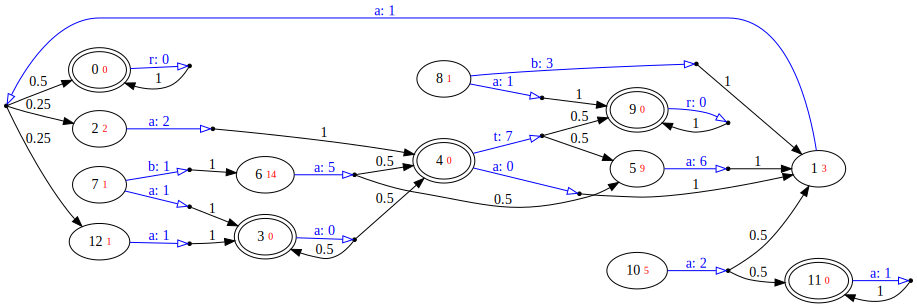

In [3]:
%run Kucera-example.ipynb
T = set([9])
targets = [True if s in T else False for s in range(m.num_states)]
m.add_action(4, {9:.5, 5:.5}, "t", 7)
m.show("S")

In [2]:
from reachability import PositiveReachability
pr = PositiveReachability(m, targets, 22)
pr.get_positive_reachability()

[0, 3, 2, 0, 0, 9, 14, 1, 1, 0, 5, 0, 1]


[inf, 18, 18, 16, 16, inf, 21, 17, 1, 0, 20, inf, 17]